In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
# Dataset
df=pd.read_csv('./../../dataset/raw_jakarta.csv', parse_dates=["date"], index_col="date")
#df['daily_case'] = df['daily_case'].str.replace(',','').astype(int)

# Cut dataset to start from 1 April 2022
df = df[31:]
df.head()

,daily_case
date,
2020-04-01,59
2020-04-02,70
2020-04-03,71
2020-04-04,57
2020-04-05,87


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 766 entries, 2020-04-01 to 2022-05-06
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   daily_case  766 non-null    int64
dtypes: int64(1)
memory usage: 12.0 KB


In [4]:
df.shape

(766, 1)

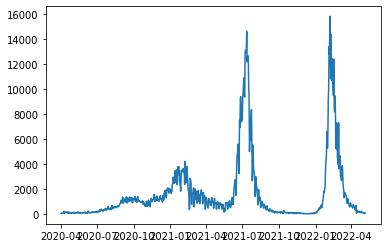

In [5]:
plt.plot(df)

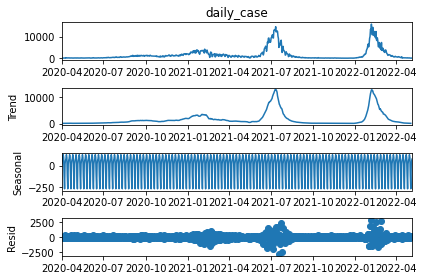

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['daily_case'])
results.plot();

In [7]:
df.shape

(766, 1)

In [8]:
# stationarity check
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [9]:
adf_test(df['daily_case'])

1. ADF :  -4.10846823571566
2. P-Value :  0.0009377753201733062
3. Num Of Lags :  19
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 746
5. Critical Values :
	 1% :  -3.439146171679794
	 5% :  -2.865422101274577
	 10% :  -2.568837245865348


In [10]:
# Split data to train and test
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

train_data=df[:train_size]
test_data=df[train_size:]

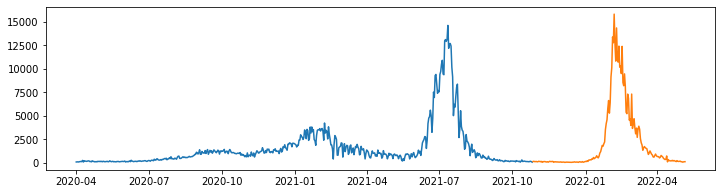

In [11]:
train_data=df[:train_size]
test_data=df[train_size:]
plt.figure(figsize=(12, 3))
plt.plot(train_data)
plt.plot(test_data)

In [12]:
from statsmodels.tsa.stattools import adfuller
#Ho: non stationary (ADF value <= 0.05)
#H1: stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [13]:
adfuller_test(df['daily_case'])

ADF Test Statistic : -4.10846823571566
p-value : 0.0009377753201733062
#Lags Used : 19
Number of Observations Used : 746
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [14]:
from pmdarima.arima import auto_arima
model = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=30,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      )

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[30] intercept   : AIC=8843.955, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=10500.191, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=8844.044, Time=0.55 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=9887.112, Time=1.07 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=10707.199, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[30] intercept   : AIC=8845.990, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[30] intercept   : AIC=8845.940, Time=0.77 sec
 ARIMA(1,0,1)(0,0,2)[30] intercept   : AIC=8845.629, Time=3.86 sec
 ARIMA(1,0,1)(1,0,0)[30] intercept   : AIC=8844.117, Time=0.69 sec
 ARIMA(1,0,1)(1,0,2)[30] intercept   : AIC=8847.172, Time=6.16 sec
 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=8843.936, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=8844.941, Time=0.02 sec
 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=8845.919, Time=0.67 sec
 ARIMA(1,0,0)(0,0,2)[30] intercept   : AIC=8845.750, Time=3.16 sec
 ARIMA(1,0,0)(1,0

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  574
Model:             SARIMAX(5, 0, 1)x(0, 0, 1, 30)   Log Likelihood               -4395.267
Date:                            Sun, 29 May 2022   AIC                           8806.533
Time:                                    13:26:14   BIC                           8841.355
Sample:                                         0   HQIC                          8820.115
                                            - 574                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0471      0.041      1.163      0.245      -0.032       0.127
ar.L2          0.6943      0.032     21.623      0.000       0.631       0.757
ar.L3          0.0591      0.034      1.718      0.086      -0.008       0.127
ar.L4          0.2482      0.018     13.808      0.000       0.213       0.283
ar.L5         -0.0778      0.031     -2.530      0.011      -0.138      -0.018
ma.L1          0.8995      0.031     29.355      0.000       0.839       0.960
ma.S.L30      -0.1291      0.033     -3.881      0.000      -0.194      -0.064
sigma2      2.612e+05   6528.103     40.009      0.000    2.48e+05    2.74e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              5548.00
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):              43.96   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model

ARIMA(order=(5, 0, 1), scoring_args={}, seasonal_order=(0, 0, 1, 30),
      suppress_warnings=True, with_intercept=False)

In [17]:
# Split data to train and test
df = df.values
df = df.astype('float32')
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

train_data=df[0:train_size]
test_data=df[train_size:len(df)]

history = [x for x in train_data]
predictions = []

In [18]:
train_size

574

In [19]:
predictions

[]

In [20]:
from statsmodels.tsa.arima.model import ARIMA
# walk-forward validation
for t in range(len(test_data)):
	model = ARIMA(history, order=(5,1,0), seasonal_order=(0,0,0,30))
	model_fit = model.fit()
	output = model_fit.forecast(steps=1)
	yhat = output[0]
	predictions.append(yhat)
	obs = test_data[t]
	history.append(obs) #append real observation to history
	print('predicted=%f, expected=%f' % (yhat, obs))
    
    

predicted=48.765927, expected=105.000000
predicted=104.635487, expected=131.000000
predicted=118.862808, expected=96.000000
predicted=100.377921, expected=96.000000
predicted=108.792725, expected=113.000000
predicted=98.337606, expected=83.000000
predicted=76.587899, expected=77.000000
predicted=89.647356, expected=132.000000
predicted=131.721557, expected=111.000000
predicted=99.724243, expected=119.000000
predicted=124.548329, expected=68.000000
predicted=71.963779, expected=117.000000
predicted=109.489871, expected=29.000000
predicted=35.605724, expected=93.000000
predicted=99.411030, expected=95.000000
predicted=102.442167, expected=107.000000
predicted=90.397461, expected=71.000000
predicted=90.595398, expected=54.000000
predicted=45.103533, expected=92.000000
predicted=95.038475, expected=36.000000
predicted=32.502049, expected=79.000000
predicted=91.777136, expected=130.000000
predicted=127.103252, expected=100.000000
predicted=81.161030, expected=97.000000
predicted=110.282352,

In [21]:
import math
from sklearn.metrics import mean_squared_error
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 937.698


In [22]:
train_data

array([[   59.],
       [   70.],
       [   71.],
       [   57.],
       [   87.],
       [  103.],
       [  113.],
       [   90.],
       [  228.],
       [   53.],
       [  190.],
       [  156.],
       [  135.],
       [  122.],
       [  143.],
       [  174.],
       [  170.],
       [  101.],
       [  113.],
       [   74.],
       [  183.],
       [  110.],
       [  122.],
       [   78.],
       [   78.],
       [  104.],
       [   66.],
       [  124.],
       [  110.],
       [  106.],
       [  135.],
       [   92.],
       [  129.],
       [   80.],
       [  132.],
       [  106.],
       [   82.],
       [   96.],
       [   98.],
       [  125.],
       [   81.],
       [   96.],
       [  180.],
       [  135.],
       [   86.],
       [  101.],
       [  127.],
       [   79.],
       [   94.],
       [   84.],
       [   70.],
       [  106.],
       [  111.],
       [  112.],
       [   76.],
       [   87.],
       [  109.],
       [  100.],
       [  125.

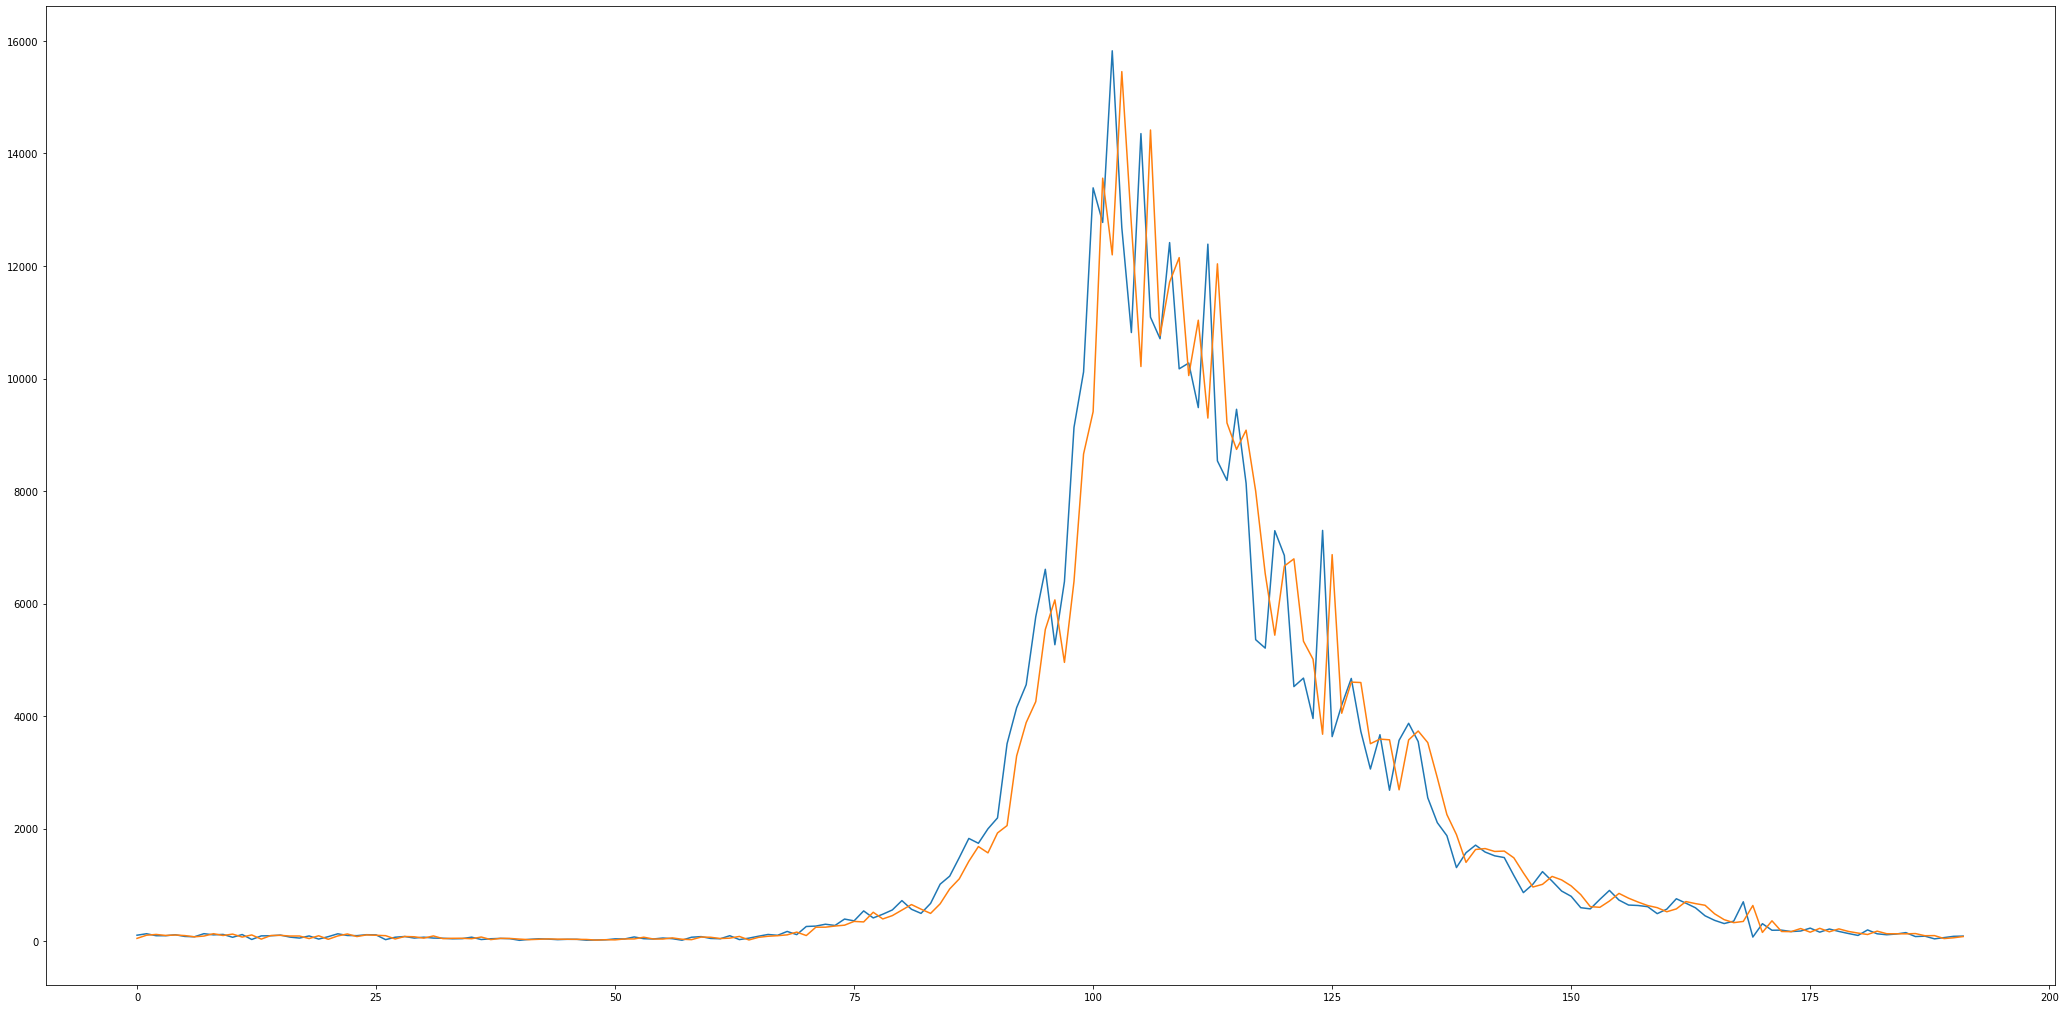

In [23]:
plt.figure(figsize=(36,18)) 
plt.plot(test_data)
plt.plot(predictions)

plt.show()

In [24]:
history

[array([59.], dtype=float32),
 array([70.], dtype=float32),
 array([71.], dtype=float32),
 array([57.], dtype=float32),
 array([87.], dtype=float32),
 array([103.], dtype=float32),
 array([113.], dtype=float32),
 array([90.], dtype=float32),
 array([228.], dtype=float32),
 array([53.], dtype=float32),
 array([190.], dtype=float32),
 array([156.], dtype=float32),
 array([135.], dtype=float32),
 array([122.], dtype=float32),
 array([143.], dtype=float32),
 array([174.], dtype=float32),
 array([170.], dtype=float32),
 array([101.], dtype=float32),
 array([113.], dtype=float32),
 array([74.], dtype=float32),
 array([183.], dtype=float32),
 array([110.], dtype=float32),
 array([122.], dtype=float32),
 array([78.], dtype=float32),
 array([78.], dtype=float32),
 array([104.], dtype=float32),
 array([66.], dtype=float32),
 array([124.], dtype=float32),
 array([110.], dtype=float32),
 array([106.], dtype=float32),
 array([135.], dtype=float32),
 array([92.], dtype=float32),
 array([129.], dtype

In [25]:
model = ARIMA(history, order=(5,1,0), seasonal_order=(0,0,0,30))

model_fit = model.fit()
output = model_fit.forecast(steps=1)
# multi-step out-of-sample forecast
start_index = len(history)
end_index = start_index + 29
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in df]
day = 1
for yhat in forecast:
	print('Day %d: %f' % (day, yhat))
	history.append(yhat)
	day += 1

# forecast = model_fit.forecast(steps=30)

Day 1: 83.915365
Day 2: 89.712350
Day 3: 88.849036
Day 4: 86.664159
Day 5: 86.935552
Day 6: 87.711417
Day 7: 86.994202
Day 8: 87.015676
Day 9: 87.295378
Day 10: 87.222932
Day 11: 87.119172
Day 12: 87.210736
Day 13: 87.213134
Day 14: 87.174566
Day 15: 87.186184
Day 16: 87.199877
Day 17: 87.187917
Day 18: 87.187230
Day 19: 87.192580
Day 20: 87.190903
Day 21: 87.189081
Day 22: 87.190666
Day 23: 87.190788
Day 24: 87.190051
Day 25: 87.190284
Day 26: 87.190528
Day 27: 87.190317
Day 28: 87.190298
Day 29: 87.190399
Day 30: 87.190367


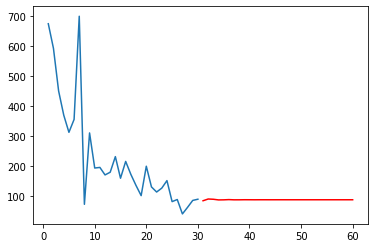

In [26]:
day_new=np.arange(1,31) # dari data 30 hari terakhir
day_pred=np.arange(31,61) #predict 30 hari kedepan

plt.plot(day_new, df[736:766])
plt.plot(day_pred, forecast, color='red')
plt.show()